In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from torchvision.models import densenet121

In [3]:
model = densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(in_features=num_features, out_features=2, bias=True)
model = model.to(device)

epochs = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
creterion = nn.CrossEntropyLoss()

d:\Anconda\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anconda\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import gen_train_test_data
trainloader = gen_train_test_data.train_loader
testloader = gen_train_test_data.test_loader

losses = []
accuracies = []
precisions = []
recalls = []
F1_scores = []
turns = 0

for epoch in range(epochs):
    for x, y in trainloader:
        inputs = x.to(device)
        labels = y.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = creterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        with torch.no_grad():
            turns += 1
            _, predicted = torch.max(outputs.cpu(), dim=1)
            labels = labels.cpu()
            tp = torch.sum((labels.reshape(-1) == 1) & (predicted == 1)).item()
            tn = torch.sum((labels.reshape(-1) == 0) & (predicted == 0)).item()
            fp = torch.sum((labels.reshape(-1) == 0) & (predicted == 1)).item()
            fn = torch.sum((labels.reshape(-1) == 1) & (predicted == 0)).item()
            accuracy = (tp+tn)/(tp+tn+fp+fn)
            precision = tp/(tp+fp) if ((tp+fp)!=0) else 0
            recall = tp/(tp+fn) if ((tp+fn)!=0) else 0
            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            F1_scores.append((2*precision*recall/(precision+recall)) if ((precision+recall)!=0) else 0)
            print(f'turns:{turns}, loss:{loss.item()}')

turns:1, loss:0.7370544075965881
turns:2, loss:0.21723465621471405
turns:3, loss:0.2913530170917511
turns:4, loss:0.12537702918052673
turns:5, loss:0.041511740535497665
turns:6, loss:0.11747276782989502
turns:7, loss:0.1949213594198227
turns:8, loss:0.13292963802814484
turns:9, loss:0.017344234511256218
turns:10, loss:2.012791395187378
turns:11, loss:0.011792496778070927
turns:12, loss:0.06108260899782181
turns:13, loss:0.0149226114153862
turns:14, loss:0.12251319736242294
turns:15, loss:0.030047481879591942
turns:16, loss:0.01187505666166544
turns:17, loss:0.4554155766963959
turns:18, loss:0.05843137949705124
turns:19, loss:0.18317361176013947
turns:20, loss:0.003618986811488867
turns:21, loss:0.06567960977554321
turns:22, loss:0.033550925552845
turns:23, loss:0.15391242504119873
turns:24, loss:0.023313414305448532
turns:25, loss:0.06728006899356842
turns:26, loss:0.13503257930278778
turns:27, loss:0.21562424302101135
turns:28, loss:0.013347603380680084
turns:29, loss:0.00348037737421

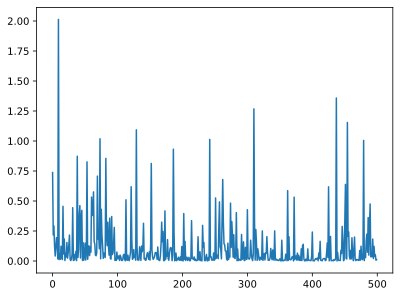

In [5]:
plt.plot(range(len(losses)), losses)

训练集精度: 1.0%


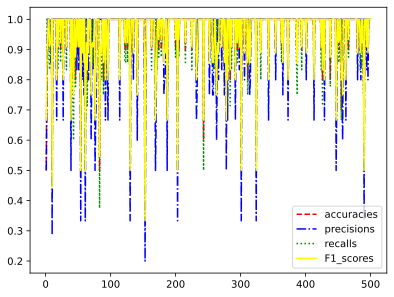

In [6]:
lens = len(accuracies)+1
plt.plot(range(1, lens), accuracies, color='red', linestyle='--', label='accuracies')
plt.plot(range(1, lens), precisions, color='blue', linestyle='-.', label='precisions')
plt.plot(range(1, lens), recalls, color='green', linestyle=':', label='recalls')
plt.plot(range(1, lens), F1_scores, color='yellow', linestyle='-', label='F1_scores')
plt.legend()

print(f'训练集精度: {100*accuracies[len(accuracies)-1]}%')

In [7]:
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.cpu(), dim=1)
        labels = labels.cpu()
        tp += torch.sum((labels.reshape(-1) == 1) & (predicted == 1)).item()
        tn += torch.sum((labels.reshape(-1) == 0) & (predicted == 0)).item()
        fp += torch.sum((labels.reshape(-1) == 0) & (predicted == 1)).item()
        fn += torch.sum((labels.reshape(-1) == 1) & (predicted == 0)).item()
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp) if ((tp+fp)!=0) else 0
recall = tp/(tp+fn) if ((tp+fn)!=0) else 0
print(f'测试集准确率: {100*accuracy}%')
print(f'测试集精确率: {100*precision}%')
print(f'测试集召回率: {100*recall}%')
print(f'测试集F1值: {(2*precision*recall/(precision+recall)) if ((precision+recall)!=0) else 0}')

测试集准确率: 95.49019607843138%
测试集精确率: 95.66929133858267%
测试集召回率: 95.29411764705881%
测试集F1值: 0.9548133595284872


In [ ]:
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.cpu(), dim=1)
        for i in range(len(predicted)):
            print(f'predict:{predicted[i]}, label:{labels[i]}')

In [8]:
# torch.save({'model': model.state_dict()}, './mymodel/densenet121/epoch1_95.50%.pth')